In [ ]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import pyreadr
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/data/Master_Thesis_data/Raw_data'
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'

# Overlapped cells
black_list = [277420, 195486]

# Load Body clusters data

In [4]:
temp_path = os.path.join(params['base_path'], 'features_background_subtracted_mean_normalised.rds')
temp_data = pyreadr.read_r(temp_path)
body_clusters_df = temp_data[None]

# Load TFDS

In [5]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [6]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=371>,
 'train': <tfds.core.SplitInfo num_examples=2962>,
 'validation': <tfds.core.SplitInfo num_examples=370>}

In [7]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [8]:
metadata_df = tfds_metadata['metadata_df']
mask = metadata_df.mapobject_id_cell.isin(black_list)
metadata_df = metadata_df[~mask].copy()

In [9]:
channels_df = tfds_metadata['channels_df']
channel_names = [c.split("_")[1:] for c in channels_df.name.values]
channel_names = ["_".join(c) for c in channel_names]
channels_df['channel_name'] = channel_names
channels_df

,original_channel_id,name,train_98_percentile,train_mean_after_clipping,train_stddev_after_clipping,type,TFDS_channel_id,channel_name
0,0.0,00_DAPI,69.300003,29.277029,14.289816,input,0.0,DAPI
1,1.0,07_H2B,310.299988,128.472672,67.600372,input,1.0,H2B
2,2.0,01_CDK9_pT186,46.889076,10.841645,10.662010,input,2.0,CDK9_pT186
3,3.0,03_CDK9,90.797798,24.890778,20.744143,input,3.0,CDK9
4,4.0,05_GTF2B,188.166107,76.841652,45.399426,input,4.0,GTF2B
5,5.0,07_SETD1A,91.989853,20.670820,20.641857,input,5.0,SETD1A
6,6.0,08_H3K4me3,105.921074,34.419682,24.227314,input,6.0,H3K4me3
7,7.0,09_SRRM2,273.374664,39.124294,58.492748,input,7.0,SRRM2
8,8.0,10_H3K27ac,175.104874,59.614319,42.007408,input,8.0,H3K27ac
9,9.0,11_KPNA2_MAX,115.093430,41.293499,23.342470,input,9.0,KPNA2_MAX


# Add Body cluster data to metadata

In [10]:
column_names = ['Nuclei_Intensity_mean_00_EU', 
                'PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_11_PML',
                'PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100',
                'NCL_Bodies_Cells_Mean_Intensity_mean_21_NCL'
               ]


temp_df = body_clusters_df[['mapobject_id']+column_names].copy()
temp_df.columns = ['mapobject_id_cell']+column_names

metadata_df = metadata_df.merge(temp_df,
                                left_on='mapobject_id_cell',
                                right_on='mapobject_id_cell',
                                how='left')
metadata_df

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set,Nuclei_Intensity_mean_00_EU,PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_11_PML,PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100,NCL_Bodies_Cells_Mean_Intensity_mean_21_NCL
0,263042,263055,plate01,J16,0,0,0,0,4,0,plate01,J16,0,0,0,0,4,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,8401.0,39.610201,282.212391,14.709787,34.481345,122.127518,29.408288,48.079878,56.508154,71.844750,93.999276,108.771761,157.808500,85.331438,43.616172,323.670767,128.386167,134.658031,18.805303,57.414965,26.659837,122.008728,35.669525,62.715594,133.643428,77.230008,283.199741,6.970504,92.891114,280.267874,41.649294,350.631178,356.940289,10.909557,8.600135,1.771257,431.543626,7754.927152,9285.622307,0.553571,train,295.651200,14.239390,77.636384,130.742375
1,263043,263056,plate01,J16,0,0,0,0,5,0,plate01,J16,0,0,0,0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,12207.0,34.884746,249.743762,14.587963,33.729957,104.787060,25.446742,35.599046,54.977671,48.061287,90.354757,97.722536,145.751775,95.141995,43.284735,308.379265,118.856662,125.728553,14.722060,52.481306,21.451844,122.747143,30.401393,53.993867,124.670275,81.619971,272.290742,9.256049,120.165421,267.314880,39.224038,322.807908,387.219828,10.134157,7.880916,1.749512,461.474236,8818.934136,11041.621938,0.598214,test,340.314412,55.544466,98.035286,119.153892
2,263044,263057,plate01,J16,0,0,0,0,6,0,plate01,J16,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,15734.0,31.429217,184.722779,7.892179,19.263491,81.864454,23.929299,29.536900,39.606383,39.047856,77.348039,12.910413,149.859577,42.855445,25.530594,219.118552,102.575527,125.740665,5.120140,27.724444,24.187370,49.106275,29.276163,35.680201,85.295744,60.602490,232.305672,8.395510,124.383677,193.414682,36.115297,273.154826,252.115717,7.854372,8.116748,1.803605,372.570739,5740.956972,7330.808440,0.723214,train,255.279691,73.870288,34.977926,92.379168
3,263045,263058,plate01,J16,0,0,0,0,7,0,plate01,J16,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,15767.0,43.349090,241.460906,18.110119,44.601291,122.976267,40.604674,48.760110,58.076779,77.012867,121.283321,104.755645,159.792550,84.807594,43.961097,319.584115,120.314566,120.470444,25.555966,60.243330,21.220701,140.246102,27.944981,60.354207,169.718381,102.371663,264.648847,10.370258,116.424263,268.396552,43.573547,351.399875,357.762600,10.338172,7.913029,1.773024,369.910382,8085.528636,9678.381810,0.660714,test,253.049242,82.836866,217.320382,76.152642
4,263047,263060,plate01,J16,0,0,0,0,9,0,plate01,J16,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,11930.0,28.164459,149.241408,27.710272,72.874109,148.002903,51.391368,56.976488,116.255474,56.907744,66.943473,97.452245,187.995952,53.530015,60.917580,134.426297,121.980833,121.369045,59.501243,54.852952,26.389251,162.722979,36.026263,79.981471,237.625004,150.247531,255.964144,18.029298,188.560486,192.446750,66.494555,242.252349,174.614508,9.784177,8.899475,1.970130,552.887343,15128.646940,13469.590947,0.625000,train,433.913778,47.531559,160.612987,120.968292
...,...,...,...,...,...,...,...,...,

# Analysis

In [15]:
mean_EU_channel = metadata_df['00_EU_avg']
mean_EU = metadata_df['Nuclei_Intensity_mean_00_EU'].values
mean_SP100 = metadata_df['PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100'].values
mean_PML = metadata_df['PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_11_PML'].values
mean_NCL = metadata_df['NCL_Bodies_Cells_Mean_Intensity_mean_21_NCL'].values

EU_SP100_corr = np.corrcoef(mean_EU, mean_SP100)[0,1]
chEU_SP100_corr = np.corrcoef(mean_EU_channel, mean_SP100)[0,1]
EU_PML_corr = np.corrcoef(mean_EU, mean_PML)[0,1]
SP100_PML_corr = np.corrcoef(mean_SP100, mean_PML)[0,1]
EU_NCL_corr = np.corrcoef(mean_EU, mean_NCL)[0,1]

print(EU_SP100_corr, chEU_SP100_corr, EU_PML_corr, SP100_PML_corr, EU_NCL_corr)

0.2330855307308965 0.2082391569671535 0.006317927580320849 0.35282688003918505 -0.014579514517189014


Cel_cycle: G1, 0.20324158285226065
Cel_cycle: S, -0.025837828263732106
Cel_cycle: G2, 0.04442597068782496


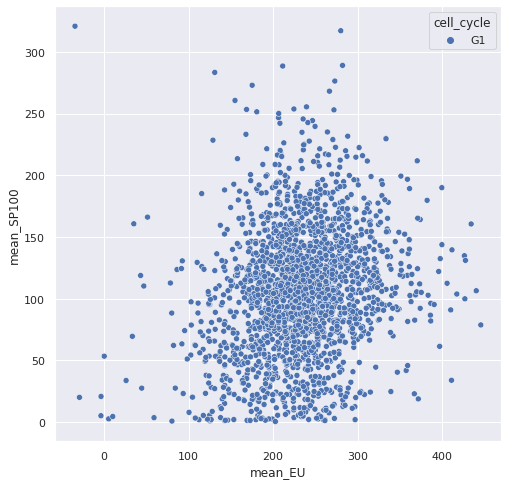

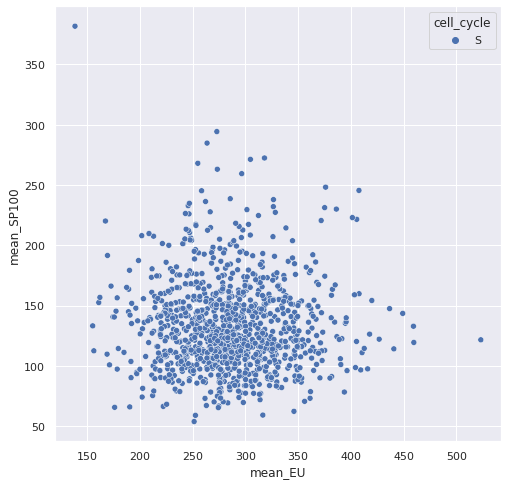

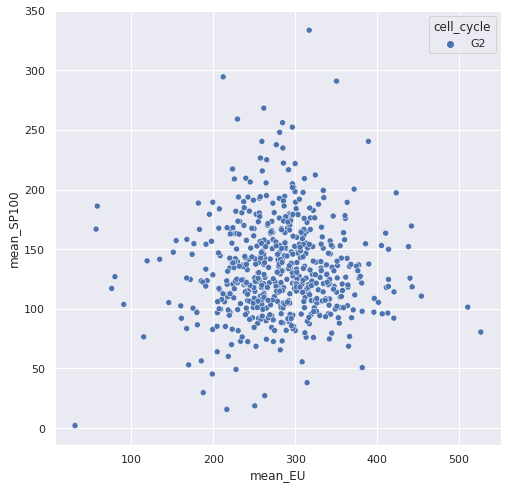

In [12]:
cell_cycles = ['G1', 'S', 'G2']
for cc in cell_cycles:
    mask = metadata_df['cell_cycle'] == cc
    temp_df = metadata_df[mask]
    
    mean_EU = temp_df['Nuclei_Intensity_mean_00_EU'].values
    mean_SP100 = temp_df['PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100'].values
    EU_SP100_corr = np.corrcoef(mean_EU, mean_SP100)[0,1]
    
    print('Cel_cycle: {}, {}'.format(cc, EU_SP100_corr))
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=temp_df,
                x='Nuclei_Intensity_mean_00_EU',
                y='PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100',
                hue='cell_cycle'
               )
    plt.ylabel('mean_SP100')
    plt.xlabel('mean_EU')

<AxesSubplot:xlabel='Nuclei_Intensity_mean_00_EU', ylabel='PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100'>

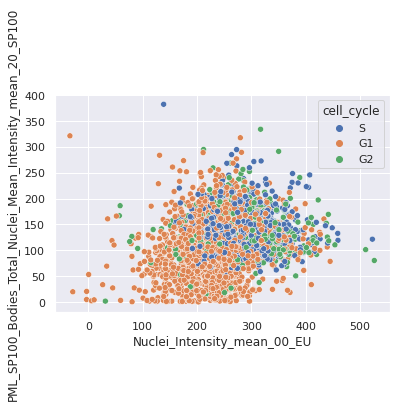

In [13]:
sns.scatterplot(data=metadata_df,
                x='Nuclei_Intensity_mean_00_EU',
                y='PML_SP100_Bodies_Total_Nuclei_Mean_Intensity_mean_20_SP100',
                hue='cell_cycle'
               )

# correlation between EU and NCL

In [16]:
[col for col in body_clusters_df.columns if ('SON' in col) and ('mean' in col)]

['SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_00_BG488',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_00_BG568',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_01_PABPC1',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_02_CDK7',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_03_RPS6',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_04_SUPT5H',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_05_Sm',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_07_POLR2A',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_09_CCNT1',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_10_POL2RA_pS2',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_11_PML',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_12_YAP1',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_13_POL2RA_pS5',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_15_U2SNRNPB',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_17_SRSF2',
 'SON_SRRM2_Bodies_Total_Nuclei_Std_Intensity_mean_18_NONO',
 